In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
# Data Collection
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876106,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167580,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742661,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400551,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565193,132079200


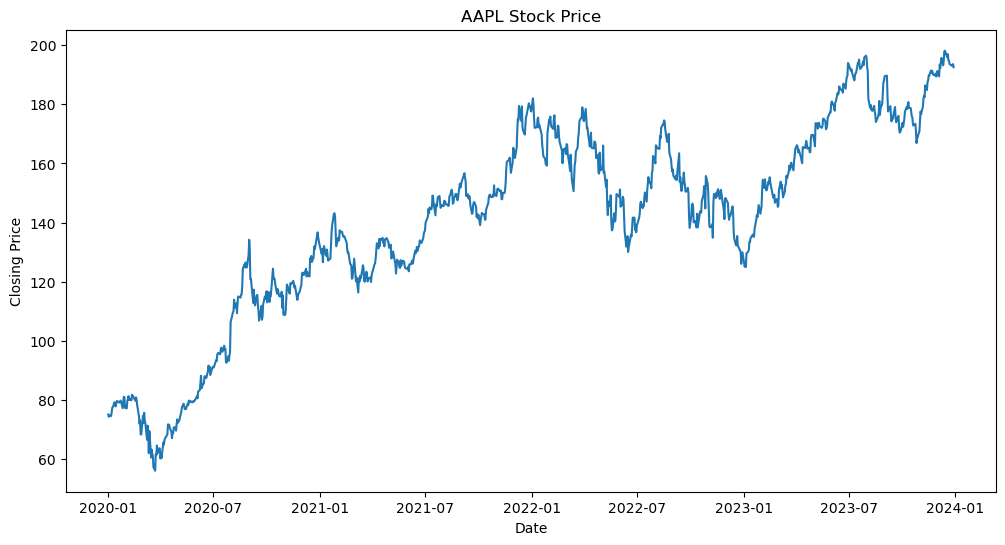

In [3]:
# Visualize Data
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [4]:
# Data Preprocessing
# Feature Selection
data = stock_data[['Close']]

# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting Data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [5]:
# Prepare Data for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data to fit LSTM input requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
# Define the Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
model.fit(X_train, y_train, batch_size=1, epochs=1)

 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


743/743 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0072


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


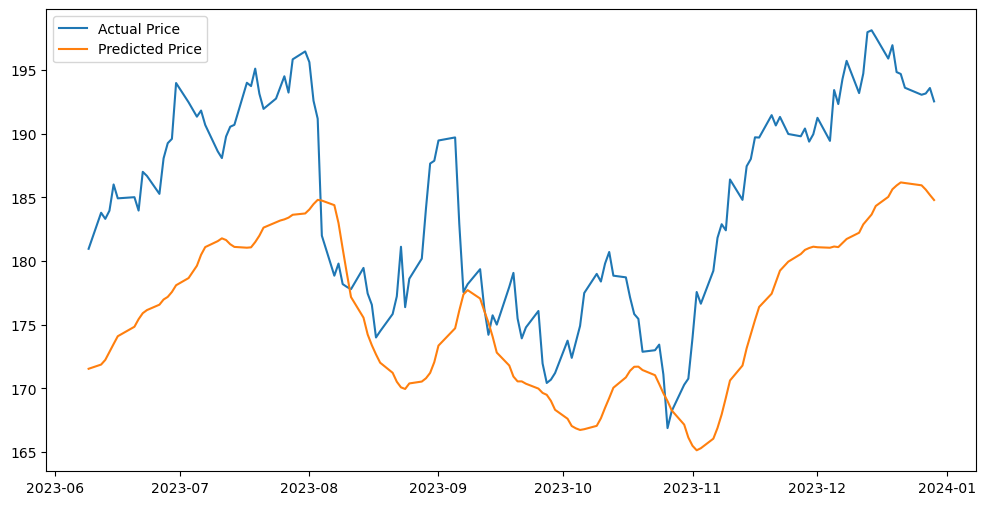

In [7]:
# Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Adjust the Test Data for Plotting
adjusted_test_data = test_data[time_step + 1:]
adjusted_test_data = scaler.inverse_transform(adjusted_test_data)

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + time_step + 1:], adjusted_test_data, label='Actual Price')
plt.plot(data.index[train_size + time_step + 1:], predictions, label='Predicted Price')
plt.legend()
plt.show()

In [8]:
rmse = np.sqrt(mean_squared_error(adjusted_test_data, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 9.643936958276814


## Backtesting with yfinance (Apple) from 2015 to 2019

In [9]:
# Setup Backtesting Environment
class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()

# Apple data from yfinance
data = yf.download('AAPL', start='2015-01-01', end='2019-01-01')
bt = Backtest(data, SmaCross, commission=.002, exclusive_orders=True)
stats = bt.run()

# Plotting Results
bt.plot(filename='backtest_results.html', open_browser=True)

[*********************100%%**********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/anaconda3/lib/python3.12/site-packages/b

GridPlot(id='p1325', ...)

## Simulation with actual data from yfinance (Apple)

## SMA Long & Short

In [34]:
import time
import numpy as np
import datetime
import yfinance as yf

def trade_yfinance():
    ticker = 'AAPL'
    data = yf.download(ticker, period='1mo', interval='1h')  # Download 1 month of hourly data
    close_prices = data['Close'].tolist()  # Convert the close prices to a list for simulation

    # Parameters for SMA calculation
    sma_short_period = 10
    sma_long_period = 20

    # Variables for simulation
    current_position = None
    cash = 100000  # Initial virtual cash
    stock_qty = 0
    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(minutes=5)  # Simulate for 5 minutes

    index = 0

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 5 minutes.")
            break

        print("Running simulation loop...")

        # Get the current price
        if index < len(close_prices):
            current_price = close_prices[index]
            index += 1
        else:
            print("End of historical price data.")
            break

        # Extract Close Prices for SMA Calculation (take the last `sma_long_period` prices)
        if index >= sma_long_period:
            recent_prices = close_prices[index - sma_long_period:index]

            # Calculate Moving Averages
            sma_short = np.mean(recent_prices[-sma_short_period:])
            sma_long = np.mean(recent_prices[-sma_long_period:])

            # Debug information for moving averages
            print(f"SMA Short: {sma_short}, SMA Long: {sma_long}")

            # Buy Signal
            if sma_short > sma_long and current_position is None:
                qty = int(cash // current_price)
                if qty > 0:
                    stock_qty = qty
                    cash -= stock_qty * current_price
                    current_position = 'long'
                    print(f"Bought {stock_qty} shares at {current_price}, Remaining Cash: {cash}")

            # Sell Signal
            elif sma_short < sma_long and current_position == 'long':
                cash += stock_qty * current_price
                print(f"Sold {stock_qty} shares at {current_price}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None
                
        time.sleep(1)

trade_yfinance()


[*********************100%%**********************]  1 of 1 completed


Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
SMA Short: 222.23701019287108, SMA Long: 221.0812644958496
Bought 448 shares at 222.94000244140625, Remaining Cash: 122.87890625
Running simulation loop...
SMA Short: 222.39200897216796, SMA Long: 221.23576431274415
Running simulation loop...
SMA Short: 222.46700897216797, SMA Long: 221.3567642211914
Running simulation loop...
SMA Short: 222.6245086669922, SMA Long: 221.60701446533204
Running simulation loop...
SMA Short: 222.66951904296874, SMA Long: 221.

## Adding Total Profits/Losses

In [37]:
import time
import numpy as np
import datetime
import yfinance as yf

def trade_yfinance():
    ticker = 'AAPL'
    data = yf.download(ticker, period='1mo', interval='1h')  # Download 1 month of hourly data
    close_prices = data['Close'].tolist()  # Convert the close prices to a list for simulation

    # Parameters for SMA calculation
    sma_short_period = 10
    sma_long_period = 20

    # Variables for simulation
    current_position = None
    cash = 100000  # Initial virtual cash
    stock_qty = 0
    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(minutes=5)  # Simulate for 5 minutes

    index = 0
    total_profit = 0  # Track total profit or loss

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 5 minutes.")
            break

        print("Running simulation loop...")

        # Get the current price
        if index < len(close_prices):
            current_price = close_prices[index]
            index += 1
        else:
            print("End of historical price data.")
            break

        # Extract Close Prices for SMA Calculation (take the last `sma_long_period` prices)
        if index >= sma_long_period:
            recent_prices = close_prices[index - sma_long_period:index]
        else:
            continue

        # Calculate Moving Averages
        sma_short = np.mean(recent_prices[-sma_short_period:])
        sma_long = np.mean(recent_prices[-sma_long_period:])

        # Debug information for moving averages
        print(f"SMA Short: {sma_short}, SMA Long: {sma_long}")

        # Buy Signal
        if sma_short > sma_long and current_position is None:
            qty = int(cash // current_price)
            stock_qty += qty
            cash -= stock_qty * current_price
            current_position = 'long'
            print(f"Bought {stock_qty} shares at {current_price}, Remaining Cash: {cash}")

        # Sell Signal
        elif sma_short < sma_long and current_position == 'long':
            cash += stock_qty * current_price
            profit = (current_price * stock_qty) - (sma_short * stock_qty)
            total_profit += profit
            print(f"Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
            stock_qty = 0
            current_position = None

        # Debug profit/loss tracking
        print(f"Total Profit/Loss so far: {total_profit}")

        time.sleep(1)

    # Final evaluation of performance
    if current_position == 'long':
        # Sell any remaining stock at the last available price
        cash += stock_qty * current_price
        profit = (current_price * stock_qty) - (sma_short * stock_qty)
        total_profit += profit
        print(f"Final Sale: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
        stock_qty = 0
        current_position = None

    print(f"Total Profit/Loss at the end of simulation: {total_profit}")

trade_yfinance()

[*********************100%%**********************]  1 of 1 completed


Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
SMA Short: 222.23701019287108, SMA Long: 221.0812644958496
Bought 448 shares at 222.94000244140625, Remaining Cash: 122.87890625
Total Profit/Loss so far: 0
Running simulation loop...
SMA Short: 222.39200897216796, SMA Long: 221.23576431274415
Total Profit/Loss so far: 0
Running simulation loop...
SMA Short: 222.46700897216797, SMA Long: 221.3567642211914
Total Profit/Loss so far: 0
Running simulation loop...
SMA Short: 222.6245086669922, SMA Long: 221.607

## Adding Stop-Loss and Take Profit Logic

In [39]:
import time
import numpy as np
import datetime
import yfinance as yf

def trade_yfinance():
    ticker = 'AAPL'
    data = yf.download(ticker, period='1mo', interval='1h')  # Download 1 month of hourly data
    close_prices = data['Close'].tolist()  # Convert the close prices to a list for simulation

    # Parameters for SMA calculation
    sma_short_period = 10
    sma_long_period = 20

    # Stop-loss and take-profit parameters (percentage)
    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.04  # 4% take profit

    # Variables for simulation
    current_position = None
    cash = 100000  # Initial virtual cash
    stock_qty = 0
    entry_price = 0
    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(minutes=5)  # Simulate for 5 minutes

    index = 0
    total_profit = 0  # Track total profit or loss

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 5 minutes.")
            break

        print("Running simulation loop...")

        # Get the current price
        if index < len(close_prices):
            current_price = close_prices[index]
            index += 1
        else:
            print("End of historical price data.")
            break

        # Extract Close Prices for SMA Calculation (take the last `sma_long_period` prices)
        if index >= sma_long_period:
            recent_prices = close_prices[index - sma_long_period:index]
        else:
            continue

        # Calculate Moving Averages
        sma_short = np.mean(recent_prices[-sma_short_period:])
        sma_long = np.mean(recent_prices[-sma_long_period:])

        # Debug information for moving averages
        print(f"SMA Short: {sma_short}, SMA Long: {sma_long}")

        # Buy Signal
        if sma_short > sma_long and current_position is None:
            qty = int(cash // current_price)
            stock_qty += qty
            cash -= stock_qty * current_price
            entry_price = current_price
            current_position = 'long'
            print(f"Bought {stock_qty} shares at {current_price}, Remaining Cash: {cash}")

        # Stop-loss or Take-profit check
        if current_position == 'long':
            if (current_price <= entry_price * (1 - stop_loss_pct)):
                # Stop-loss triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Stop-Loss Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

            elif (current_price >= entry_price * (1 + take_profit_pct)):
                # Take-profit triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Take-Profit Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

        # Sell Signal
        elif sma_short < sma_long and current_position == 'long':
            cash += stock_qty * current_price
            profit = (current_price - entry_price) * stock_qty
            total_profit += profit
            print(f"Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
            stock_qty = 0
            current_position = None

        # Debug profit/loss tracking
        print(f"Total Profit/Loss so far: {total_profit}")

        time.sleep(1)

    # Final evaluation of performance
    if current_position == 'long':
        # Sell any remaining stock at the last available price
        cash += stock_qty * current_price
        profit = (current_price - entry_price) * stock_qty
        total_profit += profit
        print(f"Final Sale: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
        stock_qty = 0
        current_position = None

    print(f"Total Profit/Loss at the end of simulation: {total_profit}")

trade_yfinance()


[*********************100%%**********************]  1 of 1 completed


Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
SMA Short: 222.23701019287108, SMA Long: 221.0812644958496
Bought 448 shares at 222.94000244140625, Remaining Cash: 122.87890625
Total Profit/Loss so far: 0
Running simulation loop...
SMA Short: 222.39200897216796, SMA Long: 221.23576431274415
Total Profit/Loss so far: 0
Running simulation loop...
SMA Short: 222.46700897216797, SMA Long: 221.3567642211914
Total Profit/Loss so far: 0
Running simulation loop...
SMA Short: 222.6245086669922, SMA Long: 221.607

## Adding Relative Strength Index (RSI) for better entry and exit decisions

In [42]:
import time
import numpy as np
import datetime
import yfinance as yf

def calculate_rsi(prices, period=14):
    delta = np.diff(prices)
    gain = np.maximum(delta, 0)
    loss = np.abs(np.minimum(delta, 0))

    avg_gain = np.mean(gain[:period])
    avg_loss = np.mean(loss[:period])

    rsi = []
    for i in range(period, len(prices)):
        avg_gain = (avg_gain * (period - 1) + gain[i-1]) / period
        avg_loss = (avg_loss * (period - 1) + loss[i-1]) / period
        rs = avg_gain / avg_loss if avg_loss != 0 else 0
        rsi_value = 100 - (100 / (1 + rs))
        rsi.append(rsi_value)

    return rsi

def trade_yfinance():
    ticker = 'AAPL'
    data = yf.download(ticker, period='1mo', interval='1h')  # Download 1 month of hourly data
    close_prices = data['Close'].tolist()  # Convert the close prices to a list for simulation

    # Parameters for SMA calculation
    sma_short_period = 10
    sma_long_period = 20
    rsi_period = 14

    # Stop-loss and take-profit parameters (percentage)
    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.04  # 4% take profit

    # Variables for simulation
    current_position = None
    cash = 100000  # Initial virtual cash
    stock_qty = 0
    entry_price = 0
    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(minutes=5)  # Simulate for 5 minutes

    index = 0
    total_profit = 0  # Track total profit or loss

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 5 minutes.")
            break

        print("Running simulation loop...")

        # Get the current price
        if index < len(close_prices):
            current_price = close_prices[index]
            index += 1
        else:
            print("End of historical price data.")
            break

        # Extract Close Prices for SMA Calculation (take the last `sma_long_period` prices)
        if index >= sma_long_period:
            recent_prices = close_prices[index - sma_long_period:index]
        else:
            continue

        # Calculate Moving Averages
        sma_short = np.mean(recent_prices[-sma_short_period:])
        sma_long = np.mean(recent_prices[-sma_long_period:])

        # Calculate RSI
        if index >= sma_long_period + rsi_period:
            rsi_values = calculate_rsi(close_prices[index - (sma_long_period + rsi_period):index], rsi_period)
            rsi = rsi_values[-1]
        else:
            continue

        # Debug information for moving averages and RSI
        print(f"SMA Short: {sma_short}, SMA Long: {sma_long}, RSI: {rsi}")

        # Buy Signal with RSI Confirmation
        if sma_short > sma_long and current_position is None and rsi < 30:
            qty = int(cash // current_price)
            stock_qty += qty
            cash -= stock_qty * current_price
            entry_price = current_price
            current_position = 'long'
            print(f"Bought {stock_qty} shares at {current_price}, Remaining Cash: {cash}")

        # Stop-loss or Take-profit check
        if current_position == 'long':
            if (current_price <= entry_price * (1 - stop_loss_pct)):
                # Stop-loss triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Stop-Loss Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

            elif (current_price >= entry_price * (1 + take_profit_pct)):
                # Take-profit triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Take-Profit Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

        # Sell Signal with RSI Confirmation
        elif sma_short < sma_long and current_position == 'long' and rsi > 70:
            cash += stock_qty * current_price
            profit = (current_price - entry_price) * stock_qty
            total_profit += profit
            print(f"Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
            stock_qty = 0
            current_position = None

        # Debug profit/loss tracking
        print(f"Total Profit/Loss so far: {total_profit}")

        time.sleep(1)

    # Final evaluation of performance
    if current_position == 'long':
        # Sell any remaining stock at the last available price
        cash += stock_qty * current_price
        profit = (current_price - entry_price) * stock_qty
        total_profit += profit
        print(f"Final Sale: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
        stock_qty = 0
        current_position = None

    print(f"Total Profit/Loss at the end of simulation: {total_profit}")

trade_yfinance()


[*********************100%%**********************]  1 of 1 completed


Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
SMA Short: 218.88143005371094, SMA Long: 220.77547454833984, RSI: 31.4967201335687

## Changed RSI thresholds (Buying/Selling)

In [45]:
import time
import numpy as np
import datetime
import yfinance as yf

def calculate_rsi(prices, period=14):
    delta = np.diff(prices)
    gain = np.maximum(delta, 0)
    loss = np.abs(np.minimum(delta, 0))

    avg_gain = np.mean(gain[:period])
    avg_loss = np.mean(loss[:period])

    rsi = []
    for i in range(period, len(prices)):
        avg_gain = (avg_gain * (period - 1) + gain[i-1]) / period
        avg_loss = (avg_loss * (period - 1) + loss[i-1]) / period
        rs = avg_gain / avg_loss if avg_loss != 0 else 0
        rsi_value = 100 - (100 / (1 + rs))
        rsi.append(rsi_value)

    return rsi

def trade_yfinance():
    ticker = 'AAPL'
    data = yf.download(ticker, period='1mo', interval='1h')  # Download 1 month of hourly data
    close_prices = data['Close'].tolist()  # Convert the close prices to a list for simulation

    # Parameters for SMA calculation
    sma_short_period = 10
    sma_long_period = 20
    rsi_period = 14

    # Stop-loss and take-profit parameters (percentage)
    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.04  # 4% take profit

    # Variables for simulation
    current_position = None
    cash = 100000  # Initial virtual cash
    stock_qty = 0
    entry_price = 0
    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(minutes=5)  # Simulate for 5 minutes

    index = 0
    total_profit = 0  # Track total profit or loss

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 5 minutes.")
            break

        print("Running simulation loop...")

        # Get the current price
        if index < len(close_prices):
            current_price = close_prices[index]
            index += 1
        else:
            print("End of historical price data.")
            break

        # Extract Close Prices for SMA Calculation (take the last `sma_long_period` prices)
        if index >= sma_long_period:
            recent_prices = close_prices[index - sma_long_period:index]
        else:
            continue

        # Calculate Moving Averages
        sma_short = np.mean(recent_prices[-sma_short_period:])
        sma_long = np.mean(recent_prices[-sma_long_period:])

        # Calculate RSI
        if index >= sma_long_period + rsi_period:
            rsi_values = calculate_rsi(close_prices[index - (sma_long_period + rsi_period):index], rsi_period)
            rsi = rsi_values[-1]
        else:
            continue

        # Debug information for moving averages and RSI
        print(f"SMA Short: {sma_short}, SMA Long: {sma_long}, RSI: {rsi}")

        # Buy Signal with Relaxed RSI Confirmation
        if sma_short > sma_long and current_position is None and rsi < 40:
            qty = int(cash // current_price)
            if qty > 0:
                stock_qty += qty
                cash -= stock_qty * current_price
                entry_price = current_price
                current_position = 'long'
                print(f"Bought {stock_qty} shares at {current_price}, Remaining Cash: {cash}")

        # Stop-loss or Take-profit check
        if current_position == 'long':
            if (current_price <= entry_price * (1 - stop_loss_pct)):
                # Stop-loss triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Stop-Loss Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

            elif (current_price >= entry_price * (1 + take_profit_pct)):
                # Take-profit triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Take-Profit Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

        # Sell Signal with Relaxed RSI Confirmation
        elif sma_short < sma_long and current_position == 'long' and rsi > 60:
            cash += stock_qty * current_price
            profit = (current_price - entry_price) * stock_qty
            total_profit += profit
            print(f"Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
            stock_qty = 0
            current_position = None

        # Debug profit/loss tracking
        print(f"Total Profit/Loss so far: {total_profit}")

        time.sleep(1)

    # Final evaluation of performance
    if current_position == 'long':
        # Sell any remaining stock at the last available price
        cash += stock_qty * current_price
        profit = (current_price - entry_price) * stock_qty
        total_profit += profit
        print(f"Final Sale: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
        stock_qty = 0
        current_position = None

    print(f"Total Profit/Loss at the end of simulation: {total_profit}")

trade_yfinance()


[*********************100%%**********************]  1 of 1 completed


Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
SMA Short: 218.88143005371094, SMA Long: 220.77547454833984, RSI: 31.4967201335687

## Adding MACD and Bollinger Bands

In [55]:
import time
import numpy as np
import datetime
import yfinance as yf

def calculate_rsi(prices, period=14):
    delta = np.diff(prices)
    gain = np.maximum(delta, 0)
    loss = np.abs(np.minimum(delta, 0))

    avg_gain = np.mean(gain[:period])
    avg_loss = np.mean(loss[:period])

    rsi = []
    for i in range(period, len(prices)):
        avg_gain = (avg_gain * (period - 1) + gain[i-1]) / period
        avg_loss = (avg_loss * (period - 1) + loss[i-1]) / period
        rs = avg_gain / avg_loss if avg_loss != 0 else 0
        rsi_value = 100 - (100 / (1 + rs))
        rsi.append(rsi_value)

    return rsi

def calculate_macd(prices, short_period=12, long_period=26, signal_period=9):
    short_ema = prices.ewm(span=short_period, adjust=False).mean()
    long_ema = prices.ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(prices, period=20, num_std=2):
    sma = prices.rolling(window=period).mean()
    rolling_std = prices.rolling(window=period).std()
    upper_band = sma + (rolling_std * num_std)
    lower_band = sma - (rolling_std * num_std)
    return upper_band, lower_band

def trade_yfinance():
    ticker = 'AAPL'
    data = yf.download(ticker, period='1mo', interval='1h')  # Download 1 month of hourly data
    close_prices = data['Close']
    close_prices_list = close_prices.tolist()  # Convert the close prices to a list for simulation

    # Parameters for SMA calculation
    sma_short_period = 10
    sma_long_period = 20
    rsi_period = 14

    # Stop-loss and take-profit parameters (percentage)
    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.04  # 4% take profit

    # Position sizing parameters
    risk_per_trade = 0.01  # 1% of total cash

    # Variables for simulation
    current_position = None
    cash = 100000  # Initial virtual cash
    stock_qty = 0
    entry_price = 0
    start_time = datetime.datetime.now()
    max_duration = datetime.timedelta(minutes=5)  # Simulate for 5 minutes

    index = 0
    total_profit = 0  # Track total profit or loss

    # Calculate MACD and Bollinger Bands
    macd_line, signal_line = calculate_macd(close_prices)
    upper_band, lower_band = calculate_bollinger_bands(close_prices)

    while True:
        # Check if the script has run for longer than the max duration
        if datetime.datetime.now() - start_time > max_duration:
            print("Stopping the script after 5 minutes.")
            break

        print("Running simulation loop...")

        # Get the current price
        if index < len(close_prices_list):
            current_price = close_prices_list[index]
            index += 1
        else:
            print("End of historical price data.")
            break

        # Extract Close Prices for SMA Calculation (take the last `sma_long_period` prices)
        if index >= sma_long_period:
            recent_prices = close_prices_list[index - sma_long_period:index]
        else:
            continue

        # Calculate Moving Averages
        sma_short = np.mean(recent_prices[-sma_short_period:])
        sma_long = np.mean(recent_prices[-sma_long_period:])

        # Calculate RSI
        if index >= sma_long_period + rsi_period:
            rsi_values = calculate_rsi(close_prices_list[index - (sma_long_period + rsi_period):index], rsi_period)
            rsi = rsi_values[-1]
        else:
            continue

        # Get MACD and Bollinger Band values
        current_macd = macd_line.iloc[index - 1]
        current_signal = signal_line.iloc[index - 1]
        current_upper_band = upper_band.iloc[index - 1]
        current_lower_band = lower_band.iloc[index - 1]

        # Debug information for moving averages, RSI, MACD, and Bollinger Bands
        print(f"SMA Short: {sma_short}, SMA Long: {sma_long}, RSI: {rsi}, MACD: {current_macd}, Signal: {current_signal}, Upper Band: {current_upper_band}, Lower Band: {current_lower_band}")

        # Buy Signal with Relaxed RSI and MACD Confirmation
        if sma_short > sma_long and current_position is None and rsi < 40 and current_macd > current_signal and current_price < current_upper_band:
            # Calculate position size based on risk per trade
            position_size = (risk_per_trade * cash) / (stop_loss_pct * current_price)
            qty = int(position_size)
            if qty > 0:
                stock_qty += qty
                cash -= stock_qty * current_price
                entry_price = current_price
                current_position = 'long'
                print(f"Bought {stock_qty} shares at {current_price}, Remaining Cash: {cash}")

        # Stop-loss or Take-profit check
        if current_position == 'long':
            if (current_price <= entry_price * (1 - stop_loss_pct)):
                # Stop-loss triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Stop-Loss Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

            elif (current_price >= entry_price * (1 + take_profit_pct)):
                # Take-profit triggered
                cash += stock_qty * current_price
                profit = (current_price - entry_price) * stock_qty
                total_profit += profit
                print(f"Take-Profit Triggered: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
                stock_qty = 0
                current_position = None

        # Sell Signal with Relaxed RSI and MACD Confirmation
        elif sma_short < sma_long and current_position == 'long' and rsi > 60 and current_macd < current_signal and current_price > current_lower_band:
            cash += stock_qty * current_price
            profit = (current_price - entry_price) * stock_qty
            total_profit += profit
            print(f"Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
            stock_qty = 0
            current_position = None

        # Debug profit/loss tracking
        print(f"Total Profit/Loss so far: {total_profit}")

        time.sleep(1)

    # Final evaluation of performance
    if current_position == 'long':
        # Sell any remaining stock at the last available price
        cash += stock_qty * current_price
        profit = (current_price - entry_price) * stock_qty
        total_profit += profit
        print(f"Final Sale: Sold {stock_qty} shares at {current_price}, Profit: {profit}, New Cash Balance: {cash}")
        stock_qty = 0
        current_position = None

    print(f"Total Profit/Loss at the end of simulation: {total_profit}")

trade_yfinance()

[*********************100%%**********************]  1 of 1 completed


Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
Running simulation loop...
SMA Short: 218.88143005371094, SMA Long: 220.77547454833984, RSI: 31.4967201335687